# Import needed modules

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
fid = drive.ListFile({'q':"title='part1.tar.gz'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('part1.tar.gz')

In [4]:
!tar -xzvf "/content/part1.tar.gz" -C "/content/"

Streaming output truncated to the last 5000 lines.
part1/14_0_2_20170103201051263.jpg
part1/30_1_0_20170104170158777.jpg
part1/62_0_0_20170104212928133.jpg
part1/27_1_0_20170103230354912.jpg
part1/65_1_0_20170110123252108.jpg
part1/60_1_0_20170110151441645.jpg
part1/44_1_3_20170109141426511.jpg
part1/62_0_3_20170104220837477.jpg
part1/25_1_0_20170111182452788.jpg
part1/10_1_0_20170109204244904.jpg
part1/27_1_0_20170105183939496.jpg
part1/1_0_2_20161219212557190.jpg
part1/9_0_0_20170110221659430.jpg
part1/67_1_0_20170110140730634.jpg
part1/62_1_0_20170110160643751.jpg
part1/1_1_3_20161220220534186.jpg
part1/39_0_2_20170104204400674.jpg
part1/27_1_3_20170104223400455.jpg
part1/37_0_4_20170104000748917.jpg
part1/2_0_2_20161219162357438.jpg
part1/2_0_2_20161219222714623.jpg
part1/52_0_2_20170104184356222.jpg
part1/60_1_0_20170110122626700.jpg
part1/32_1_0_20170103181503793.jpg
part1/41_0_0_20170109012220690.jpg
part1/1_0_4_20161221201411850.jpg
part1/60_0_0_20170111203255875.jpg
part1/1_1_

In [5]:
import os
import re
from shutil import move

def extract_age_gender(file_name):
    match = re.match(r"(\d+)_(\d+)_(\d+)_", file_name)
    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        return age, gender
    else:
        return None

def organize_images(source_dir, destination_dir):
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        if os.path.isfile(source_path):
            age_gender = extract_age_gender(filename)
            if age_gender:
                age, gender = age_gender
                age_group = f"{(age // 20) * 20}-{((age // 20) + 1) * 20}"
                destination_path = os.path.join(destination_dir, f"gender_{gender}" )
                os.makedirs(destination_path, exist_ok=True)
                move(source_path, os.path.join(destination_path, filename))

if __name__ == "__main__":
    # Modify the paths accordingly
    source_directory = "/content/part1"
    destination_directory = "/content/Dataset"

    organize_images(source_directory, destination_directory)

In [6]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Data Preprocessing

**Read data and store it in dataframe**

In [7]:
# Generate data paths with labels
data_dir = '/content/Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
df

,filepaths,labels
0,/content/Dataset/gender_0/31_0_0_2017010913432...,gender_0
1,/content/Dataset/gender_0/68_0_0_2017011120484...,gender_0
2,/content/Dataset/gender_0/33_0_0_2017010516491...,gender_0
3,/content/Dataset/gender_0/56_0_0_2017010421011...,gender_0
4,/content/Dataset/gender_0/58_0_0_2017011119522...,gender_0
...,...,...
10130,/content/Dataset/gender_1/3_1_0_20170109194109...,gender_1
10131,/content/Dataset/gender_1/22_1_0_2017010323572...,gender_1
10132,/content/Dataset/gender_1/24_1_0_2017010518364...,gender_1
10133,/content/Dataset/gender_1/66_1_0_2017011013163...,gender_1


**Split dataframe into train, valid, and test**

In [9]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [10]:
# crobed image size
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 8108 validated image filenames belonging to 2 classes.
Found 1216 validated image filenames belonging to 2 classes.
Found 811 validated image filenames belonging to 2 classes.


**Show sample from train data**

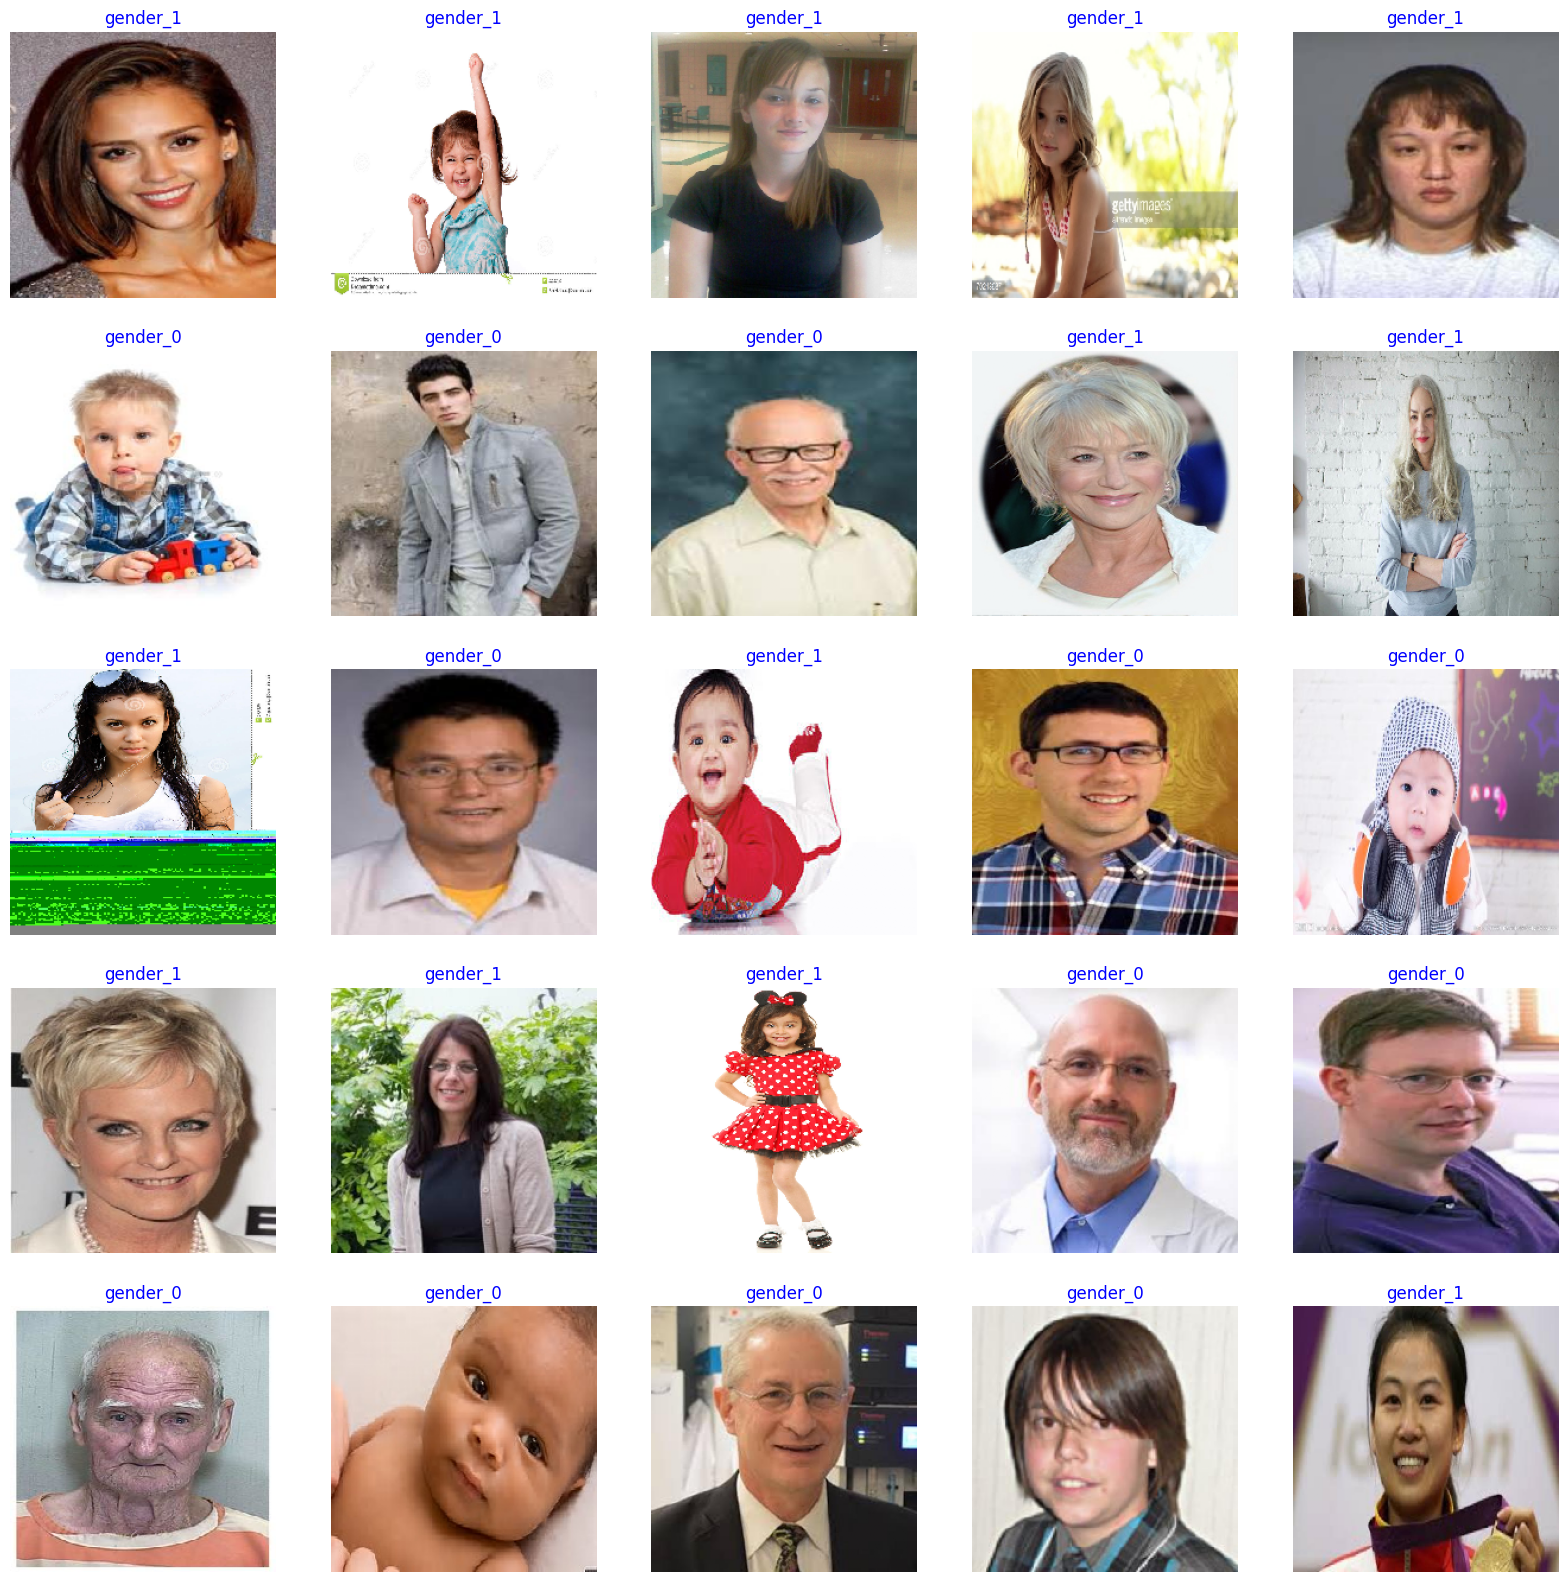

In [11]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

**Generic Model Creation**

In [12]:
# Create Model Structure
img_size = (180, 180)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'sigmoid')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

# Train model

In [13]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
254/254 [==============================] - 204s 556ms/step - loss: 3.9384 - accuracy: 0.8209 - val_loss: 1.8162 - val_accuracy: 0.8824
Epoch 2/10
254/254 [==============================] - 137s 538ms/step - loss: 1.1310 - accuracy: 0.9148 - val_loss: 0.7692 - val_accuracy: 0.8857
Epoch 3/10
254/254 [==============================] - 136s 534ms/step - loss: 0.5093 - accuracy: 0.9523 - val_loss: 0.4863 - val_accuracy: 0.8956
Epoch 4/10
254/254 [==============================] - 136s 535ms/step - loss: 0.2995 - accuracy: 0.9710 - val_loss: 0.4027 - val_accuracy: 0.8980
Epoch 5/10
254/254 [==============================] - 136s 533ms/step - loss: 0.2334 - accuracy: 0.9736 - val_loss: 0.3921 - val_accuracy: 0.8939
Epoch 6/10
254/254 [==============================] - 136s 534ms/step - loss: 0.1874 - accuracy: 0.9830 - val_loss: 0.3546 - val_accuracy: 0.9046
Epoch 7/10
254/254 [==============================] - 137s 537ms/step - loss: 0.1680 - accuracy: 0.9838 - val_loss: 0.3997 -

**Display model performance**

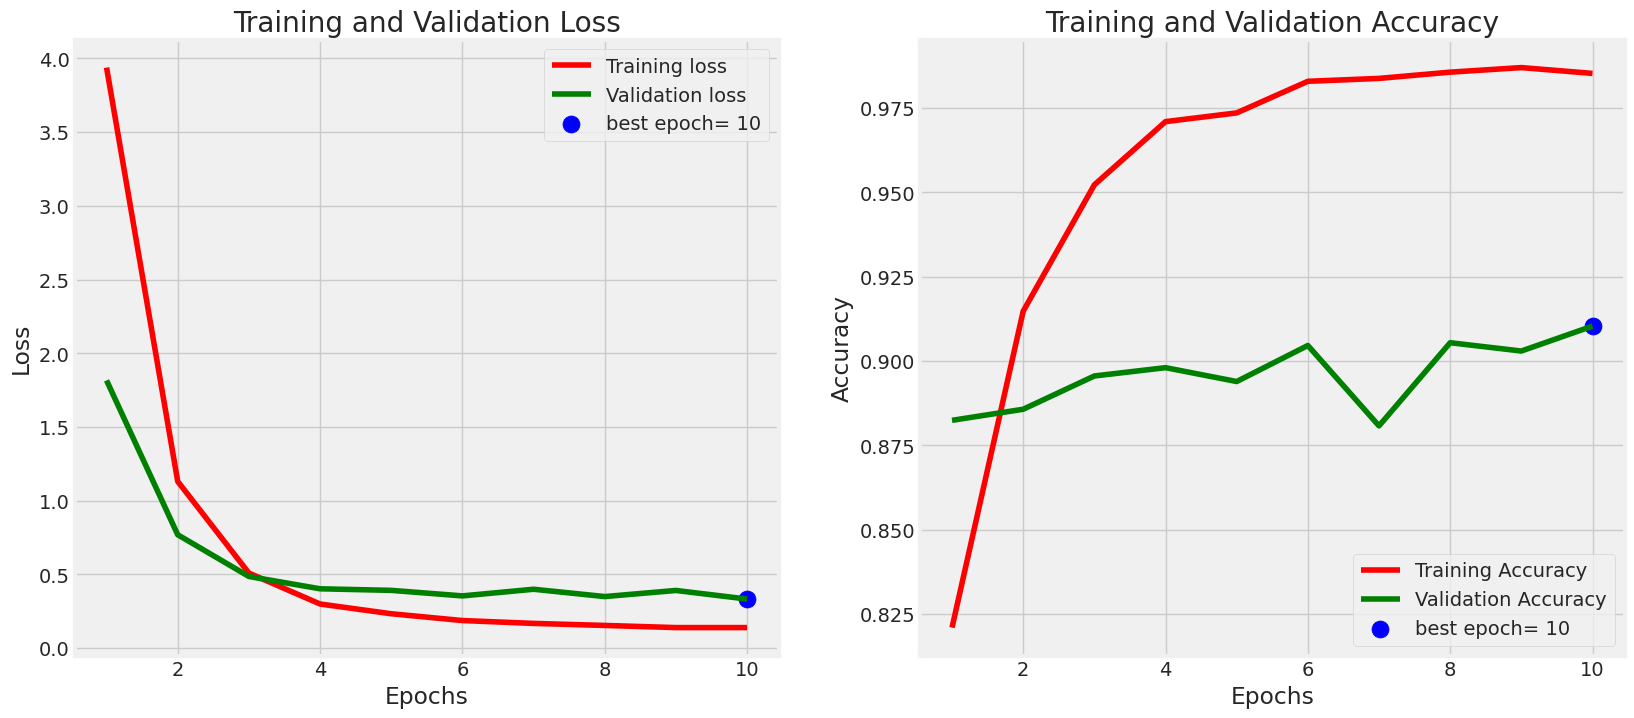

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout
plt.show()

# Evaluate model

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

254/811 [========>.....................] - ETA: 1:45 - loss: 0.0957 - accuracy: 0.9977

 38/811 [>.............................] - ETA: 2:11 - loss: 0.3332 - accuracy: 0.9104

811/811 [==============================] - 18s 20ms/step - loss: 0.3631 - accuracy: 0.9014
Train Loss:  0.09571241587400436
Train Accuracy:  0.9976566433906555
--------------------
Validation Loss:  0.3331550657749176
Validation Accuracy:  0.9103618264198303
--------------------
Test Loss:  0.36308011412620544
Test Accuracy:  0.9013563394546509


**Get Predictions**

In [16]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrics and Classification Report**

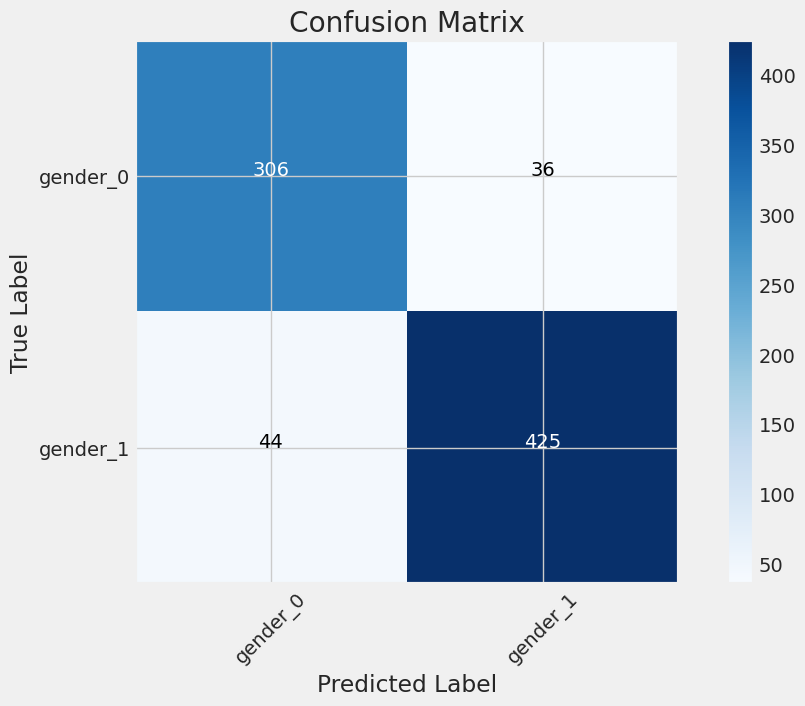

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 7))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [18]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    gender_0       0.87      0.89      0.88       342
    gender_1       0.92      0.91      0.91       469

    accuracy                           0.90       811
   macro avg       0.90      0.90      0.90       811
weighted avg       0.90      0.90      0.90       811



**Save model**

In [19]:
#Save the model
model.save('gender_predict.h5')

# Prediction using loaded_model

In [20]:
loaded_model = tf.keras.models.load_model('/content/gender_predict.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [22]:
image_path = '/content/images.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((180,180))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.sigmoid(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 99ms/step
gender_1
